In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import itertools

In [2]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pmdarima as pm
from pmdarima import model_selection
from pmdarima.arima import auto_arima

In [4]:
train_df = pd.read_csv('../input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv', parse_dates=['date'], index_col=['date'])
test_df = pd.read_csv('../input/daily-climate-time-series-data/DailyDelhiClimateTest.csv', parse_dates=['date'], index_col=['date'])

let's check the data

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      114 non-null    float64
 1   humidity      114 non-null    float64
 2   wind_speed    114 non-null    float64
 3   meanpressure  114 non-null    float64
dtypes: float64(4)
memory usage: 4.5 KB


In [7]:
train_df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [8]:
train_df['meanpressure'].max(), train_df['meanpressure'].min(), train_df['meanpressure'].mean()

(7679.333333333333, -3.0416666666666665, 1011.1045475940377)

In [9]:
train_df.loc[train_df['meanpressure'] == train_df['meanpressure'].max()].index

DatetimeIndex(['2016-03-28'], dtype='datetime64[ns]', name='date', freq=None)

As we can see, there are abnormal pressure values. It's probably a data error.Let's use Wikipedia and find out historical pressure records and filter our data.

In [10]:
train_df = train_df[(train_df['meanpressure'] > 950) & (train_df['meanpressure'] < 1090)]

Text(0.5, 0, 'Date')

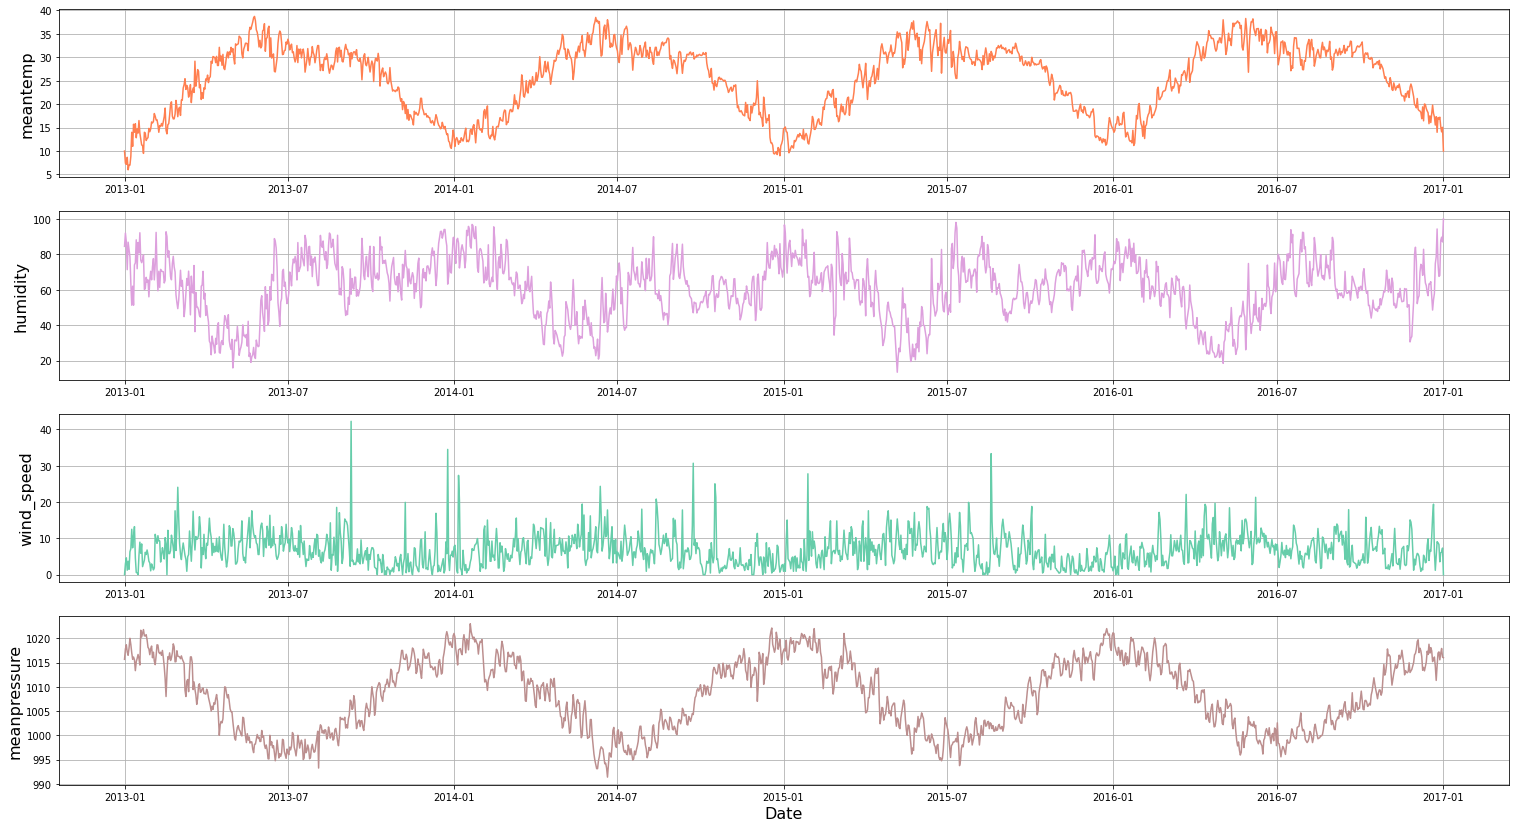

In [11]:
plt.figure(figsize=(26, 18))
colors = ['#FF7F50', '#DDA0DD', '#66CDAA', '#BC8F8F']
for i, j in enumerate(train_df.columns):
  plt.subplot(len(train_df.columns) + 1, 1, i + 1)
  plt.plot(train_df[j], color=colors[i]);
  plt.ylabel(j, fontsize=16)
  plt.grid()
plt.xlabel('Date', fontsize=16)


Let's take a closer look at the values for one year

In [12]:
train_df_2015 = train_df['2015-01-01': '2016-01-01']

Text(0.5, 0, 'Date')

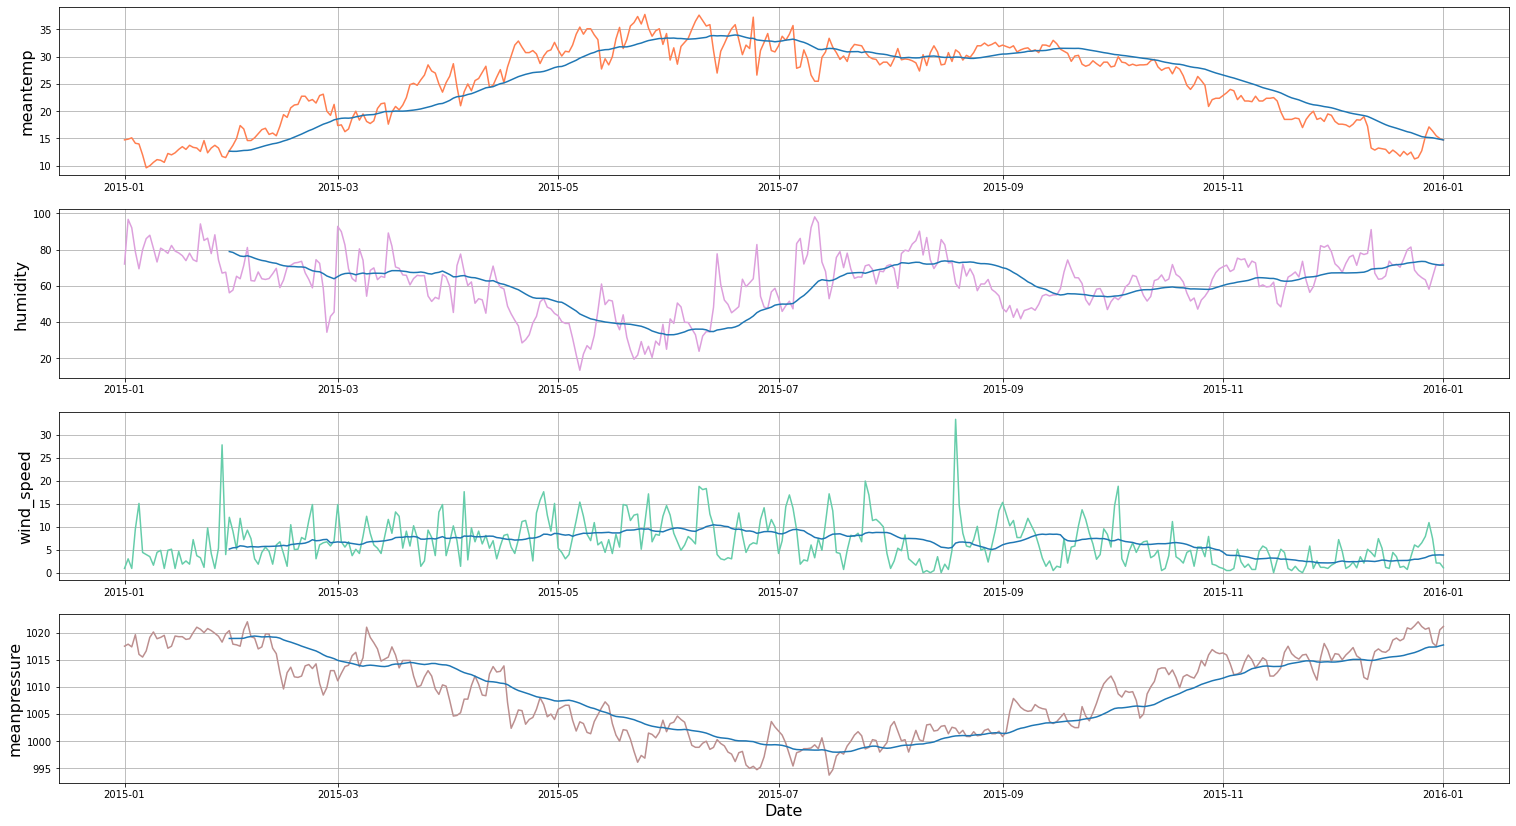

In [13]:
plt.figure(figsize=(26, 18))
colors = ['#FF7F50', '#DDA0DD', '#66CDAA', '#BC8F8F']
for i, j in enumerate(train_df_2015.columns):
  plt.subplot(len(train_df_2015.columns) + 1, 1, i + 1)
  plt.plot(train_df_2015[j], color=colors[i]);
  plt.plot(train_df_2015[j].rolling(30).mean());
  plt.ylabel(j, fontsize=16)
  plt.grid()
plt.xlabel('Date', fontsize=16)

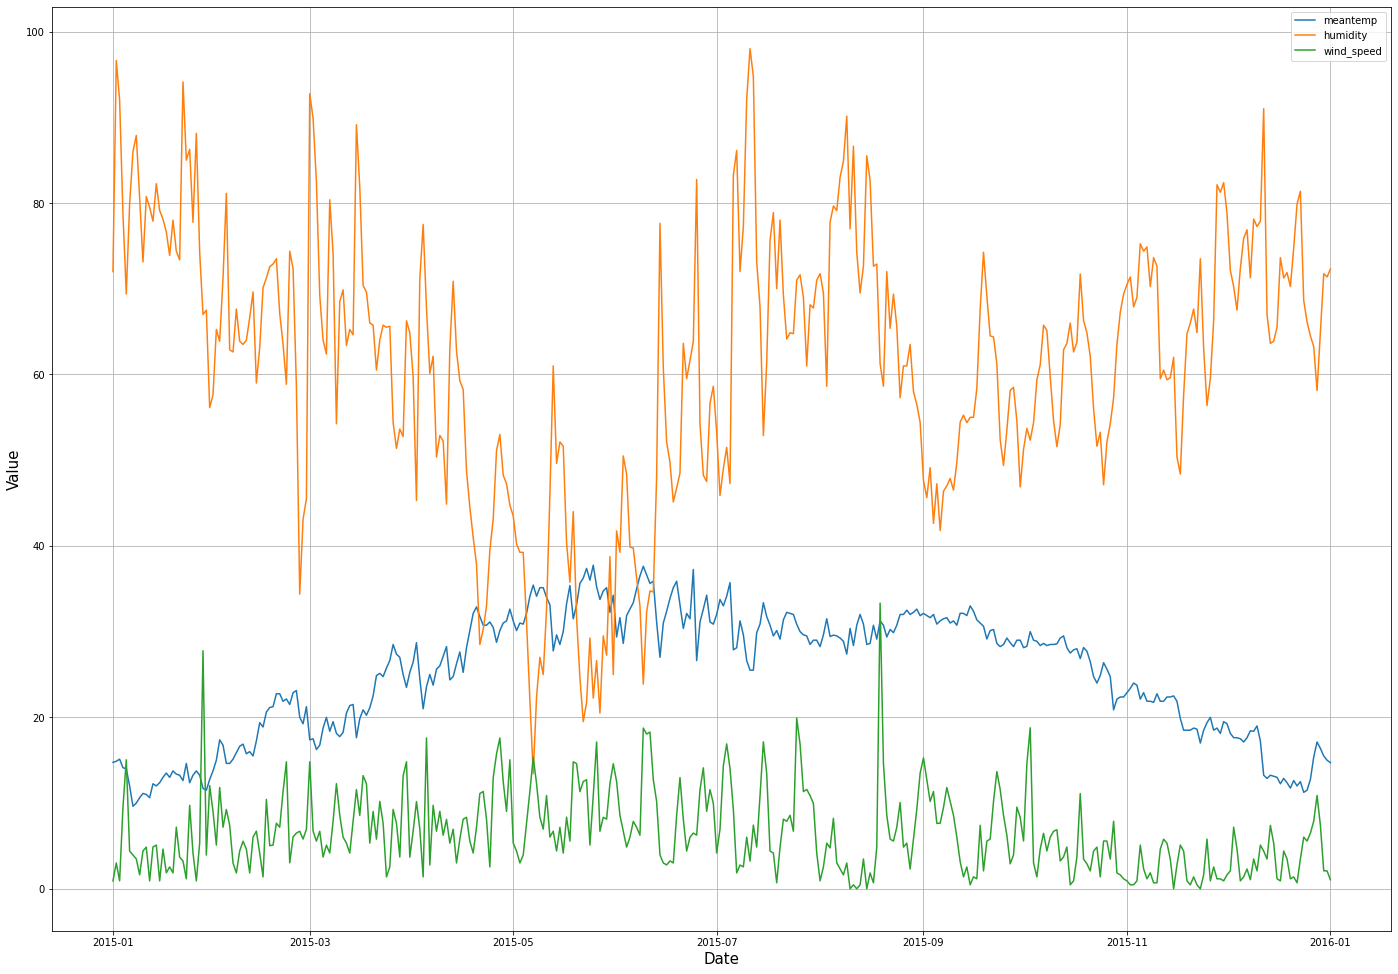

In [14]:
plt.figure(figsize=(24, 17))
for i in train_df_2015.columns[:-1]:
  plt.plot(train_df_2015[i], label=i)
  plt.xlabel("Date", fontsize = 15)
  plt.ylabel('Value', fontsize = 15)
  plt.legend()
  plt.grid(True)

It is necessary to check our series for stationarity (presence of trends, seasonal dynamics). This can be done by plotting and visual evaluation, or by using parametric criteria such as the Dickey Fuller test.

In [15]:
stationary_timeseries = []
for column in train_df.columns:
  adf_test = adfuller(train_df[column])
  if adf_test[1] < 0.05:
   stationary_timeseries.append(column)
  print(f'p-value for {column} is {adf_test[1]}')
if len(stationary_timeseries) == 0: 
  print('All time series are not stationary!')
else:
  print(f'Stationary time series: {stationary_timeseries}')

p-value for meantemp is 0.28208637476718973
p-value for humidity is 0.004233462189280544
p-value for wind_speed is 0.0024702802613417304
p-value for meanpressure is 0.23062267971511924
Stationary time series: ['humidity', 'wind_speed']


As we can see, these temperatures are non-stationary. Let's break it down using seasonal_decompose

In [16]:
ts_decomposition = seasonal_decompose(x=train_df['meantemp'], model='additive', period=365)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

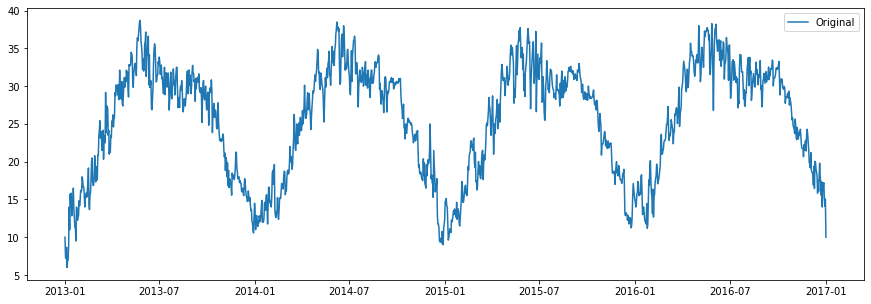

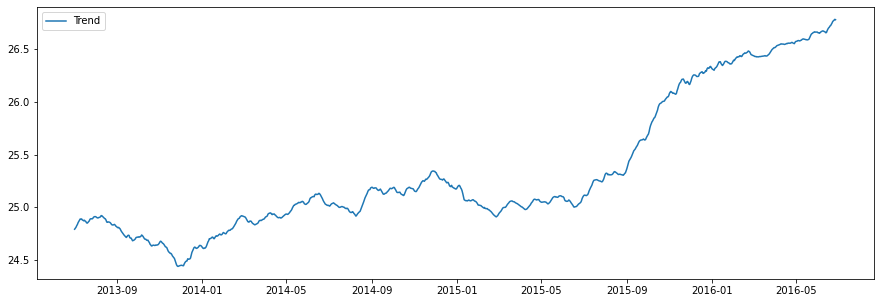

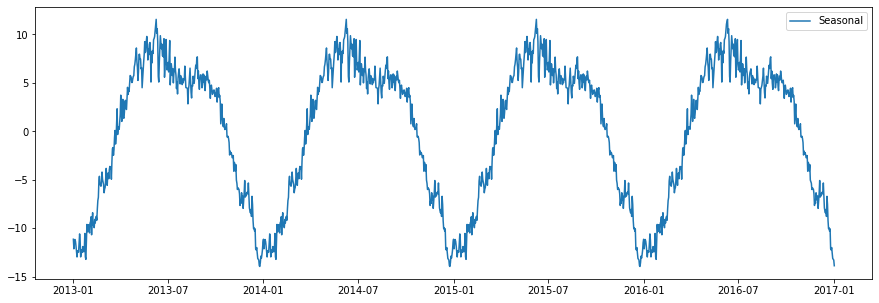

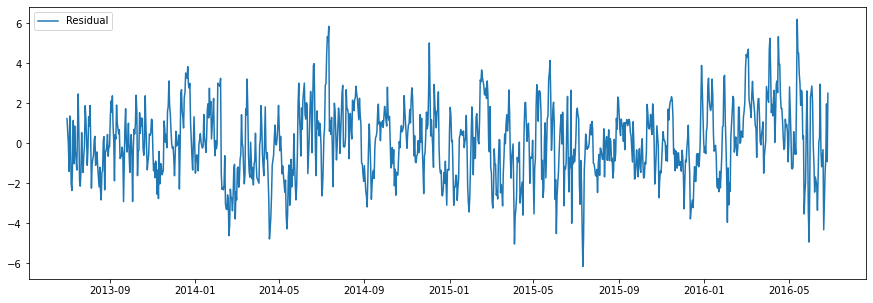

In [17]:
plt.figure(figsize=(15,5))
plt.plot(train_df['meantemp'], label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

In [18]:
print(f'p-value for decompose (residual) data - {adfuller(residual_estimate.dropna(axis=0))[1]}')

p-value for decompose (residual) data - 1.5966590169518192e-17


Our hypothesis is confirmed. The decomposition of the time series shows the presence of a trend and a seasonal component. We have two ways - to bring the series to a stationary one and use the ACF PACF graphs to determine the ARIMA parameters, or use automatic selection.

taking a logarithm, we make the data homoscedastic (reduce the spread of std)

P-value for log data 0.008095744013913645


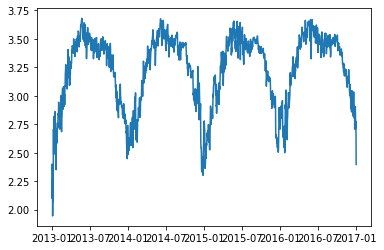

In [19]:
#log
statictic_log = adfuller(np.log1p(train_df['meantemp']))
print(f'P-value for log data {statictic_log[1]}')
log_data = np.log1p(train_df['meantemp'])
plt.plot(log_data)

By diff the series, we remove the trend and seasonal components

P-value for diff data 2.9222361166795775e-29


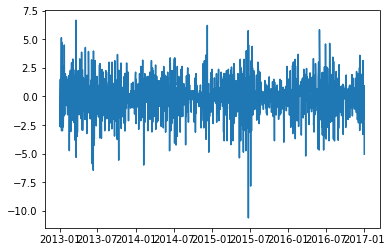

In [20]:
#diff 

statictic_diff = adfuller(train_df['meantemp'].diff().dropna())
print(f'P-value for diff data {statictic_diff[1]}')
diff_data = train_df['meantemp'].diff().dropna()
plt.plot(diff_data)

Now we can determine the parameters p and q for ARIMA using autocorrelation of series

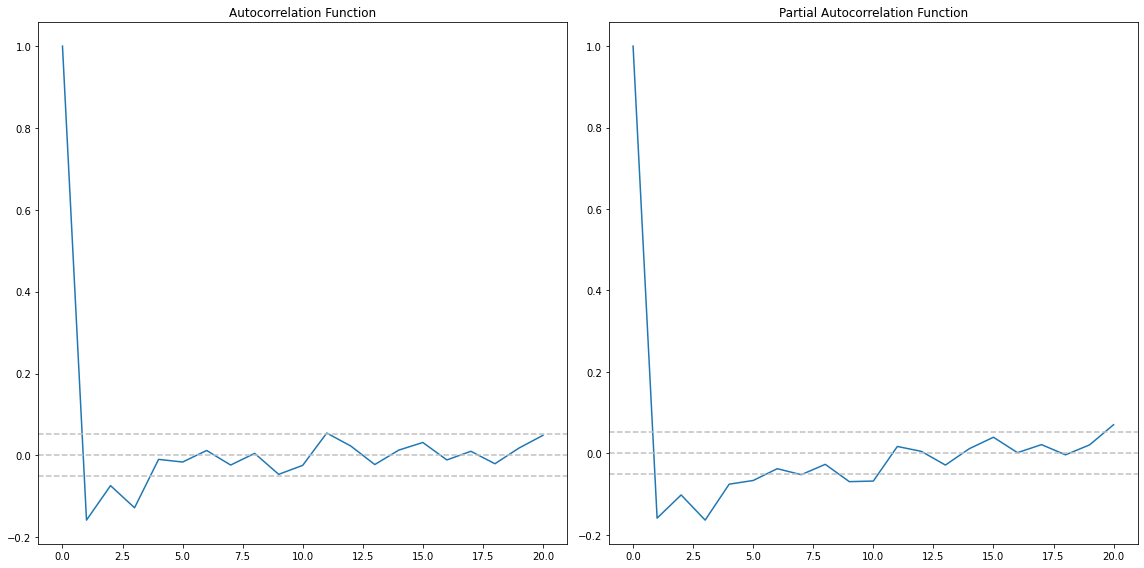

In [21]:
acf_lag = acf(diff_data.values, nlags=20)
pacf_lag = pacf(diff_data.values, nlags=20, method='ols')

plt.figure(figsize=(16,8))

plt.subplot(121)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(diff_data.values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(diff_data.values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(122)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(diff_data.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(diff_data.diff().values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

Now we know the coefficients and can 'manually' build the model. But let's try to pick up parameters using auto_arima

Plot our train and test data

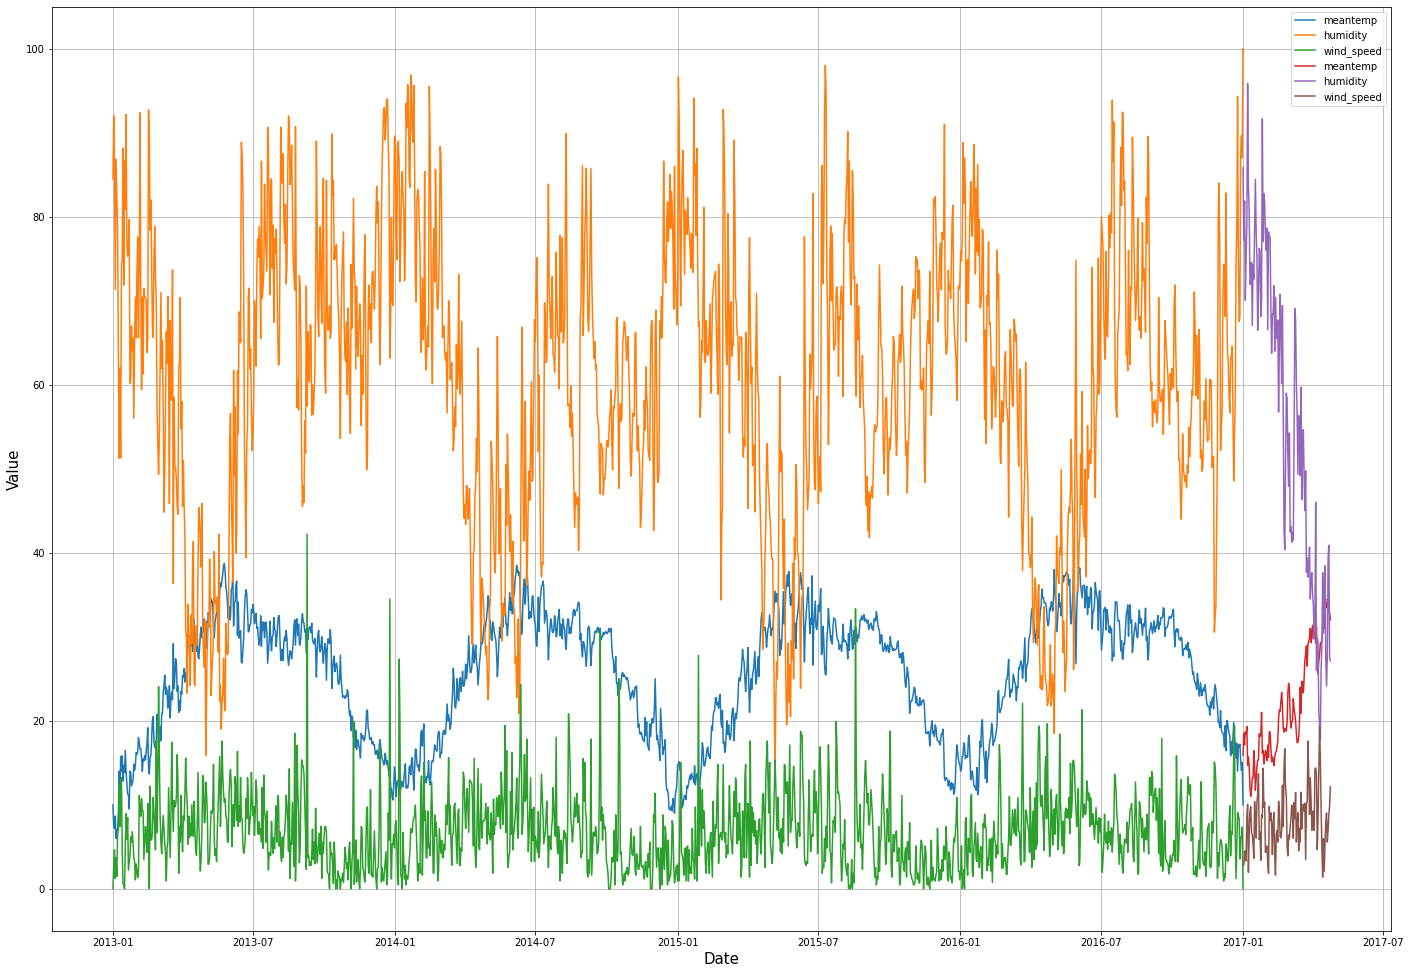

In [22]:
plt.figure(figsize=(24, 17))
for i in train_df.columns[:-1]:
  plt.plot(train_df[i], label=i)
  plt.xlabel("Date", fontsize = 15)
  plt.ylabel('Value', fontsize = 15)
  plt.legend()
  plt.grid(True)
for i in test_df.columns[:-1]:
  plt.plot(test_df[i], label=i)
  plt.xlabel("Date", fontsize = 15)
  plt.ylabel('Value', fontsize = 15)
  plt.legend()
  plt.grid(True)

In [23]:
train=train_df[:-100]

In [24]:
arima = pm.auto_arima(train_df['meantemp'][:-100],
                      X=train.drop(columns=['meantemp']),
                      error_action='ignore',
                      trace=True,
                      suppress_warnings=True,
                      maxiter=500,
                      m=4,
                      stationary=False,
                      test='adf'
                     )

print(arima.summary())
print(arima.params)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=4288.457, Time=12.69 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=8812.310, Time=0.48 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=4369.215, Time=16.11 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=6377.583, Time=7.73 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=8810.430, Time=1.10 sec
 ARIMA(2,0,2)(0,0,1)[4] intercept   : AIC=4290.800, Time=10.01 sec
 ARIMA(2,0,2)(1,0,0)[4] intercept   : AIC=4290.758, Time=13.68 sec
 ARIMA(2,0,2)(2,0,1)[4] intercept   : AIC=4290.316, Time=14.90 sec
 ARIMA(2,0,2)(1,0,2)[4] intercept   : AIC=4290.300, Time=17.67 sec
 ARIMA(2,0,2)(0,0,0)[4] intercept   : AIC=4289.046, Time=2.28 sec
 ARIMA(2,0,2)(0,0,2)[4] intercept   : AIC=4292.523, Time=17.21 sec
 ARIMA(2,0,2)(2,0,0)[4] intercept   : AIC=4292.451, Time=30.22 sec
 ARIMA(2,0,2)(2,0,2)[4] intercept   : AIC=4295.853, Time=40.51 sec
 ARIMA(1,0,2)(1,0,1)[4] intercept   : AIC=4339.779, Time=18.63 sec
 ARIMA(2,0,1)(1,0,1)[4]

Combine our validation and test data in common dateframe

In [25]:
new_test = pd.concat([train_df[-100:], test_df[1:]], axis=0)
new_test

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-09-21,33.360000,58.960000,6.092000,1005.400000
2016-09-22,30.037037,67.629630,8.107407,1008.777778
2016-09-23,31.000000,66.107143,3.571429,1005.321429
2016-09-25,31.130435,62.304348,3.147826,1004.782609
2016-09-26,31.480000,60.880000,2.986957,1006.760000
...,...,...,...,...
2017-04-20,34.500000,27.500000,5.562500,998.625000
2017-04-21,34.250000,39.375000,6.962500,999.875000
2017-04-22,32.900000,40.900000,8.890000,1001.600000


Make a prediction and plot out test and result

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


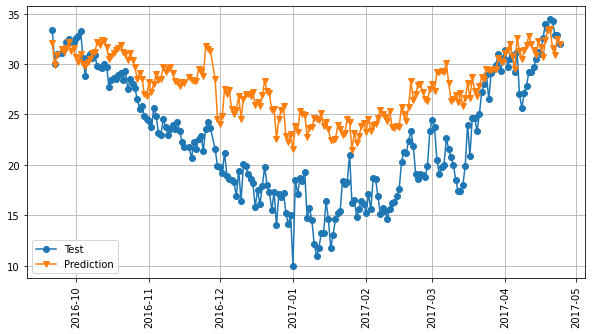

Mean Absolute Percentage Error 0.2870736383297333
Mean Squared Error 37.890915196998094
RMSE 6.155559698110164
AIC values 4283.829713651686


In [26]:
pred=arima.predict(n_periods=213, 
                   X=new_test.drop(columns=['meantemp']), 
                   alpha=0.05)

plt.figure(figsize=(10,5))
plt.grid()
ax = new_test.index
plt.plot(ax,new_test['meantemp'], marker='o', label='Test')
plt.plot(ax,pred, marker='v', label='Prediction')
plt.legend()
plt.xticks(rotation=90)
plt.show()
print("="*50)
print("="*50)
MAE=mean_absolute_percentage_error(new_test['meantemp'], pred)
print("Mean Absolute Percentage Error", MAE)
print("="*50)
MSE=mean_squared_error(new_test['meantemp'], pred)
print("Mean Squared Error",MSE)
print("="*50)
print("RMSE", (MSE)**0.5)
print("="*50)
print("AIC values {}".format(arima.aic()))

In [27]:
itogo=pd.DataFrame(new_test['meantemp'])

res=pd.DataFrame()
res['Test']=itogo['meantemp']
res['Prediction']=pred.values
res['Difference']=res['Test']-res['Prediction']
res['% Change']=abs(res['Difference']/res['Test'])*100
res.tail(10)

,Test,Prediction,Difference,% Change
date,,,,
2017-04-15,31.222222,32.243897,-1.021674,3.272267
2017-04-16,31.000000,31.641812,-0.641812,2.070360
2017-04-17,32.555556,30.703623,1.851933,5.688530
2017-04-18,34.000000,32.413145,1.586855,4.667222
2017-04-19,33.500000,33.328185,0.171815,0.512879
2017-04-20,34.500000,33.503043,0.996957,2.889731
2017-04-21,34.250000,31.587811,2.662189,7.772814
2017-04-22,32.900000,30.911542,1.988458,6.043946
2017-04-23,32.875000,32.516112,0.358888,1.091675
